In [1]:
from bggcomplex import *
from lie_algebra_module import *
from quantum_center_module import QuantumFactory
import numpy as np
import scipy
from collections import Counter

In [2]:
BGG = BGGComplex("G2")
BGG.find_cycles();

In [3]:
Solver = BGGMapSolver(BGG,BGG.zero_root)

In [4]:
Solver.solve(parallel=False);

In [5]:
BGG.compute_signs()

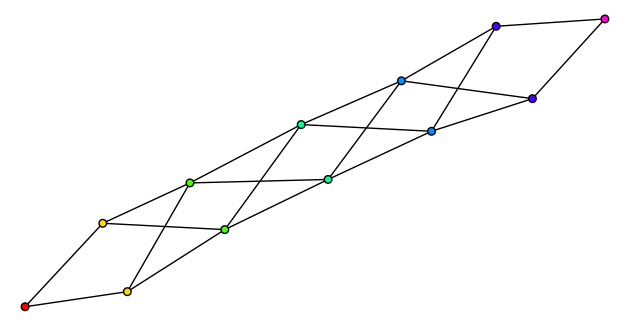

In [6]:
BGG.plot_graph().plot()

We want to implement the $U(\mathfrak g)$ action on the module
$$
    M_i^j=\bigoplus{}_{r=0}^{j+\frac k2}\left(\left(\bigodot{}^{j+\frac k2-r}\mathfrak u \right)\otimes\left(\bigwedge^r\mathfrak g\right)\otimes\left(\bigwedge{}^{j+\frac k2}\mathfrak n \right) \right)
$$
For this we need two things, one is finding a basis of this module, and second we define the action on it. Unfortunately I can't find a good out of the box implementation for either of these, so we are going to have to do it ourselves. Ideally we can use this to extend sage a little bit. 

Sagemath has a class FreeModuleTensor, it can deal with alternating and symmetric tensors. But it specifically says it can not deal with tensor products of different modules, whereas that is precisely what we need. We should investigate how this class work, and extend it with this functionality. Besides, that module seems to focus on doing stuff without a specific basis. We want to do everything in a basis, because the whole point is to compute a basis. 

We should make an instance of CombinatorialFreeModule

Next steps:
- compute phi (there is a slight discrepency between this phi and the one in Mathematica. might be because here we choose a more reasonable basis)
- construct M
- construct submodule T
- take quotients by subspaces
- compute dot regular weights
- attach it to BGG complex, compute (co)kernel dimensions

### Definition of coadjoint action

We have a pairing $\langle\,\,,\,\rangle$ on $\mathfrak g$. We also have a map on the root space, ${}^*$ sending:
$e_I \leftrightarrow f_I$, $h_i\leftrightarrow h_i$. Then the coadjoint action, corestricted to a subalgebra $\mathfrak i<\mathfrak g$ with basis $\{\alpha_i\}$,
$$
 \left.\mathrm{ad}^*\right|_{\mathfrak{i}}(X)(m) =- \sum_i\langle m,\,[X,\alpha_i^*] \rangle\alpha_i
$$
The pairing is defined by $\langle e_I,f_I\rangle=\delta_{i,j}$ and $\langle h_i,h_j\rangle=\delta_{i,j}$. We also define
$$
\varphi:\mathfrak b\to\mathfrak n\otimes\mathfrak u,\quad \varphi(m)=\sum_I f_I\otimes \left.\mathrm{ad}^*\right|_{\mathfrak{u}}(m)(e_I)
$$
Note that the image of $\varphi$ is weight zero.

## The module M

Recall:
$$
    M_j^k=\bigoplus{}_{r=0}^{j+\frac k2}\left(\left(\bigodot{}^{j+\frac k2-r}\mathfrak u \right)\otimes\left(\bigwedge^r\mathfrak g\right)\otimes\left(\bigwedge{}^{j-r}\mathfrak n \right) \right)
$$

In [7]:
maps = BGG.compute_maps(BGG.zero_root)

In [8]:
q_factory = QuantumFactory(BGG)

In [9]:
def ijk(a,b):
    return (int((a-b)/2),int((a+b)/2),-a)

In [10]:
i,j,k=ijk(2,6)

module = q_factory.M_module(j,k)
relations = q_factory.T_spanning_set(j,k)

We should have a new class WeightModule which is an extension of LieAlgebraModule, but has the function get_weight. Then we should make a new module, compute_bgg_cohomology which takes a BGG and WeightModule as input to compute BGG.

In [11]:
wtmod = q_factory.weight_module(j,k)

In [12]:
[wtmod.get_weight(key) for key in wtmod.basis_keys]
    

[-6*alpha[1] - 4*alpha[2],
 -5*alpha[1] - 4*alpha[2],
 -4*alpha[1] - 4*alpha[2],
 -4*alpha[1] - 3*alpha[2],
 -3*alpha[1] - 3*alpha[2],
 -2*alpha[1] - 3*alpha[2],
 -4*alpha[1] - 4*alpha[2],
 -3*alpha[1] - 4*alpha[2],
 -2*alpha[1] - 4*alpha[2],
 -alpha[1] - 3*alpha[2],
 -6*alpha[1] - 5*alpha[2],
 -5*alpha[1] - 5*alpha[2],
 -4*alpha[1] - 5*alpha[2],
 -3*alpha[1] - 4*alpha[2],
 -3*alpha[1] - 5*alpha[2],
 -4*alpha[1] - 3*alpha[2],
 -3*alpha[1] - 3*alpha[2],
 -2*alpha[1] - 3*alpha[2],
 -2*alpha[1] - 2*alpha[2],
 -alpha[1] - 2*alpha[2],
 -2*alpha[2],
 -2*alpha[1] - 3*alpha[2],
 -alpha[1] - 3*alpha[2],
 -3*alpha[2],
 alpha[1] - 2*alpha[2],
 -4*alpha[1] - 4*alpha[2],
 -3*alpha[1] - 4*alpha[2],
 -2*alpha[1] - 4*alpha[2],
 -alpha[1] - 3*alpha[2],
 -alpha[1] - 4*alpha[2],
 -4*alpha[1] - 2*alpha[2],
 -3*alpha[1] - 2*alpha[2],
 -2*alpha[1] - 2*alpha[2],
 -2*alpha[1] - alpha[2],
 -alpha[1] - alpha[2],
 -alpha[2],
 -2*alpha[1] - 2*alpha[2],
 -alpha[1] - 2*alpha[2],
 -2*alpha[2],
 alpha[1] - alpha[2],


In [13]:
all_weights, regular_weights = BGG.compute_weights(wtmod)

How to compute cohomology:
- We start with a weight module E. Nothing is assumed about it.
- We first of all compute all the dot regular weights of E. 
- For each dot regular weight $\mu$, define the length $\ell(\mu)$ as the length of the unique $w\in W$ such that $w\cdot\mu$ is dominant. 
- We make a list of tuples $(\mu,\,w\cdot \mu,\,\ell(\mu))$
- Let's say we want to compute cohomology in degree i. We create a list $H^i(E)$ = `[ ]`
- We select all $(\mu,\,w\cdot \mu,\,\ell(\mu))$ with $\ell(\mu)=i$
- We compute $H^i(\mathrm{BGG}(E,w\cdot\mu))$
    - If there are no $(\mu',\,w'\cdot \mu',\,\ell(\mu))$ with $w'\cdot\mu'=w\cdot \mu$ and $\ell(\mu')=i\pm 1$, then
    a priori we know that $H^i(\mathrm{BGG}(E,w\cdot\mu)) = E[\mu]$, so we just add $(\mu,\dim E[\mu])$ to the list $H^i(E)$.
    
Now assume that $\lambda=w\cdot \mu$ is a dot-regular dominant weight. 

How to compute $H^i(\mathrm{BGG}(E,\lambda))$:
- Recall that vertices of the BGG graph are labeled by elements $w\in W$. Given a regular (dominant) weight $\mu$ we get can associate to each vertex the $\mathfrak{n}$-module $E[w\cdot \lambda]$. 
- We can also associate to each edge $a\colon w\to w'$ an element $F(a)$ in $U(\mathfrak n)$ and a sign $\sigma(a)\in\{+1,-1\}$. We have $F(a)\cdot E[w\cdot \lambda]\subset E[w'\cdot \lambda]$.
- We define the column $\mathrm{BGG}_i = \bigoplus_{\ell(w)=i}E[w\cdot \lambda]$
- We define the map $\delta\colon\mathrm{BGG}_i\to\mathrm{BGG}_{i+1}$ by $\sum_{\ell(w)=i}\sum_{s(a)=w}\sigma(a)F(a)$
- We want to compute $\dim H^i = \dim \ker \delta_i - \dim \,\mathrm{coker} \delta_{i-1} =\dim\ker\delta_i-\dim \mathrm{BGG}_i+\dim\ker\delta_{i-1}^\top$
- Actually these are the maps on the weight module $M$, but we need them on $E$. For each weight we have a short exact sequence $T^j_k[\mu]\to M^j_k[\mu]\to E^j_k[\mu]$. We need to find the projection/section here. Call the section $s_\mu:E^j_k[\mu]\to M^j_k[\mu]$. Then we need to compute the kernels of the maps
$$\widetilde{\delta}_i= \sum_{\ell(w)=i}\sum_{a\colon w\to w'}s_{w'\cdot\lambda}^\top\,\sigma(a)F(a)\,s_{w\cdot \lambda}$$
$$\widetilde{\delta}^\top_{i-1}= \sum_{\ell(w)=i}\sum_{a\colon w'\to w}s_{w\cdot\lambda}^\top\,\sigma(a)F(a)\,s_{w'\cdot \lambda}$$

In [14]:
[wtmod.get_section(weight) for weight in wtmod.weight_dic.keys()];

In [15]:
wtmod.weight_dic.keys()

[-11*alpha[1] - 3*alpha[2],
 -9*alpha[1] - 5*alpha[2],
 -3*alpha[1] - 2*alpha[2],
 6*alpha[1] + 2*alpha[2],
 3*alpha[1] - 2*alpha[2],
 2*alpha[1] + 3*alpha[2],
 -2*alpha[1] - 5*alpha[2],
 8*alpha[1] + 2*alpha[2],
 -9*alpha[1] - 4*alpha[2],
 -4*alpha[2],
 3*alpha[1],
 -2*alpha[1] - 3*alpha[2],
 -2*alpha[1],
 alpha[1] - alpha[2],
 5*alpha[1] + alpha[2],
 -4*alpha[1] - alpha[2],
 5*alpha[1] - alpha[2],
 -6*alpha[1] - 4*alpha[2],
 6*alpha[1] + 4*alpha[2],
 -2*alpha[1] - 2*alpha[2],
 -6*alpha[1] - 3*alpha[2],
 3*alpha[1] + 4*alpha[2],
 -8*alpha[1] - 4*alpha[2],
 -7*alpha[1] - 5*alpha[2],
 2*alpha[1] + 2*alpha[2],
 8*alpha[1] + 3*alpha[2],
 4*alpha[1] + 4*alpha[2],
 -2*alpha[1] + 2*alpha[2],
 -3*alpha[1] - 3*alpha[2],
 -10*alpha[1] - 2*alpha[2],
 -4*alpha[1] - 3*alpha[2],
 -7*alpha[1] - 2*alpha[2],
 -10*alpha[1] - 3*alpha[2],
 3*alpha[1] - alpha[2],
 -11*alpha[1] - 4*alpha[2],
 5*alpha[1] + 3*alpha[2],
 -2*alpha[2],
 3*alpha[1] + 2*alpha[2],
 7*alpha[1] + 3*alpha[2],
 -9*alpha[1] - 6*alpha[2

In [16]:
wtmod.section

{0: [{e1112⊙e12⊙e12⊗1⊗f1∧f1112∧f12∧f2: 1,
   e11122⊙e12⊙e12⊗1⊗f1∧f11122∧f12∧f2: 1,
   e1⊙e11122⊙e12⊗1⊗f1∧f1112∧f12∧f2: 1},
  {e1112⊙e112⊙e2⊗1⊗f1∧f1112∧f12∧f2: 1},
  {e11122⊙e112⊙e112⊗1⊗f1∧f1112∧f11122∧f2: 1,
   e112⊙e112⊙e112⊗1⊗f1∧f1112∧f112∧f2: -1,
   e112⊙e112⊙e12⊗1⊗f1∧f1112∧f12∧f2: -1},
  {e1⊙e1⊗e11122⊗f1∧f1112∧f12: 1},
  {e112⊙e112⊗e2⊗f1∧f11122∧f2: 4,
   e112⊙e112⊗e2⊗f1112∧f12∧f2: -2,
   e112⊙e12⊗e2⊗f112∧f12∧f2: 3,
   e1112⊙e12⊗e2⊗f1∧f11122∧f2: 3,
   e1112⊙e12⊗e2⊗f1112∧f12∧f2: -3,
   e1112⊙e2⊗e2⊗f112∧f12∧f2: 9,
   e1112⊙e1112⊗e2⊗f1∧f11122∧f112: -27,
   e1112⊙e1112⊗e2⊗f1112∧f112∧f12: -9,
   e1112⊙e112⊗e2⊗f1112∧f112∧f2: 3,
   e1⊙e12⊗e2⊗f1∧f12∧f2: 3,
   e1⊙e1112⊗e2⊗f1∧f1112∧f2: 3,
   e1⊙e1112⊗e2⊗f1∧f112∧f12: 27,
   e1⊙e112⊗e2⊗f1∧f112∧f2: -6},
  {e112⊙e2⊗e1⊗f1∧f112∧f2: -2,
   e12⊙e12⊗e1⊗f1∧f112∧f2: -2,
   e12⊙e2⊗e1⊗f1∧f12∧f2: 1,
   e112⊙e112⊗e1⊗f1∧f1112∧f12: -2,
   e112⊙e12⊗e1⊗f1∧f1112∧f2: 1,
   e112⊙e12⊗e1⊗f1∧f112∧f12: 3,
   e1112⊙e12⊗e1⊗f1∧f1112∧f12: -2,
   e1112⊙e2⊗e1⊗f1∧f1112∧f2: 1